In [156]:
import time
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
import requests as r
import numpy as np
from tqdm import tqdm

In [169]:
REPORT_USER = "WOWA"
FAKE_HISTORY = ['http://google.com','http://hh.ru','https://hh.ru/search/vacancy?area=&fromSearchLine=true&text=']
HEADERS = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36',}

In [159]:
params = {'schedule':'',
            'area':1,
            'order_by':'publication_time',
            'employment':'full',
            'experience':'doesNotMatter',
            'excluded_text':'',
            'text':'DevOps',
            'search_field':'name',
            'items_on_page':20,
            'no_magic':'true',
            'page':0,
            'hhtmFrom':'vacancy_search_list'}

In [160]:
def generate_query(params):
    base_url = 'https://hh.ru/search/vacancy?'
    query_params = '&'.join([ f'{i}={params[i]}' for i in params])
    return base_url+query_params

In [164]:
def parse_vacancy_pages(page):
    soup = BeautifulSoup(page.text)
    vacancys = []
    for i in soup.findAll('a',{'data-qa':'vacancy-serp__vacancy-title'}):
        vacancys.append(i['href'].split('?')[0])
    return vacancys

In [165]:
def get_hh_pages(params,n_pages=5):
    pages = []
    with r.Session() as s:

        s.headers.update(HEADERS)
        [s.get(i) for i in FAKE_HISTORY];

        for _ in tqdm(range(n_pages)):

            time.sleep(np.random.poisson(5))

            response = s.get(generate_query(params=params))

            if response.status_code == 200:
                
                pages.append(parse_vacancy_pages(response))

            params['page'] +=1
        
    return sum(pages,[])


In [166]:
def parse_vaс(response):
    assert response.status_code == 200
    vac_soup = BeautifulSoup(response.text)
    vac_dict = {}

    vac_dict['Name'] = vac_soup.find('h1',{'data-qa':'vacancy-title'}).text
    vac_dict['Company'] = vac_soup.find('a',{'data-qa':'vacancy-company-name'}).text
    vac_dict['Salary'] = vac_soup.find('div',{'data-qa':'vacancy-salary'}).text

    vac_dict['Exp'] = vac_soup.find('span',{'data-qa':'vacancy-experience'}).text
    vac_dict['Type'] = vac_soup.find('p',{'data-qa':'vacancy-view-employment-mode'}).text

    try:
        vac_dict['Description'] = vac_soup.find('div',{'class':'vacancy-branded-user-content'}).text
    except:
        vac_dict['Description'] = vac_soup.find('div',{'class':'g-user-content'}).text
    try:    
        vac_dict['Tags'] = vac_soup.find('div',{'class':'bloko-tag-list'}).text
    except:
        vac_dict['Tags'] = ''


    return vac_dict

In [176]:
def collect_vacancys(vacs_url_list):
    
    vac_data_list = []
    with r.Session() as ses:
        ses.headers.update(HEADERS)
        ses.get('http://google.com')
        ses.get('http://hh.ru')
        for vac in tqdm(vacs_url_list):

            time.sleep(np.random.poisson(3))

            vac_data_list.append(
                parse_vaс(
                    ses.get(vac)
                    )
                )

    return pd.DataFrame(vac_data_list).assign(url = vacs_url_list,date = pd.to_datetime('now').date())

In [197]:
def batch_load_to_db(ttl_vac_list):

    conn = sqlite3.connect('HH_vacancy.db')

    batch_size = 27
    batch_count = len(ttl_vac_list) // batch_size +1
    print(f'Total batch count : {batch_count}' )
    for idx in range(batch_count):

        idx_start = batch_size*idx
        idx_end = batch_size*(idx+1)

        batch_data = collect_vacancys(ttl_vac_list[idx_start:idx_end])

        batch_data.assign(Query=params['text']).to_sql(name = REPORT_USER,con=conn,if_exists='append',index=False)
        
    conn.commit()
    conn.close()



In [170]:
vacancy_list = get_hh_pages(params,n_pages=10)

100%|██████████| 10/10 [00:59<00:00,  5.92s/it]


In [194]:
def check_doppelgangers(vacancy_list):
    conn = sqlite3.connect('HH_vacancy.db')
    db_urls = pd.read_sql(f'select url from {REPORT_USER}',con=conn)['url'].tolist()
    conn.close()
    uniq = list(set(vacancy_list) - set(db_urls))
    return uniq

In [195]:
uniq_vacancy_list = check_doppelgangers(vacancy_list)

In [198]:
batch_load_to_db(uniq_vacancy_list)

Total batch count : 1


100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


In [410]:
conn = sqlite3.connect('HH_vacancy.db')
df = pd.read_sql('select * from WOWA',con=conn)
conn.close()

In [411]:
df['Tags'] = df['Tags'].str.findall(r'([A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$)))')

In [413]:
df['Salary'] = df['Salary'].str.replace('\xa0','').str.extract('(\d+)').astype('float')
df['Salary'] = df['Salary'].apply(lambda x: x*80 if x < 10000 else x)

In [414]:
df ['Stack'] = df['Description'].str.findall('([A-Z][A-z]+)')

array([[<AxesSubplot:title={'center':'1–3 года'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'3–6 лет'}, xlabel='Stack'>],
       [<AxesSubplot:title={'center':'более 6 лет'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'не требуется'}, xlabel='Stack'>]],
      dtype=object)

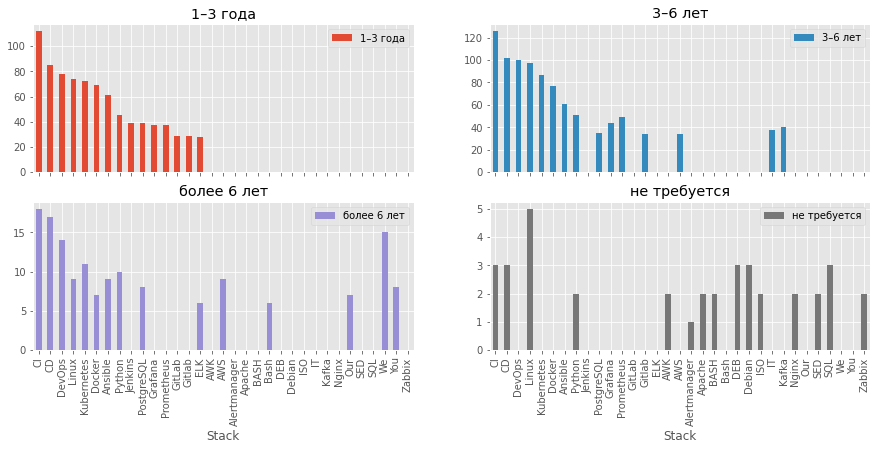

In [415]:
df[['Exp','Stack']].explode('Stack').groupby('Exp')['Stack'].value_counts()\
    .groupby(level=0).nlargest(15).reset_index(0,drop=True).unstack(0).sort_values(by='1–3 года',ascending=False).plot.bar(subplots=True,layout=(2,2))

<AxesSubplot:title={'center':'Salary'}, xlabel='Exp'>

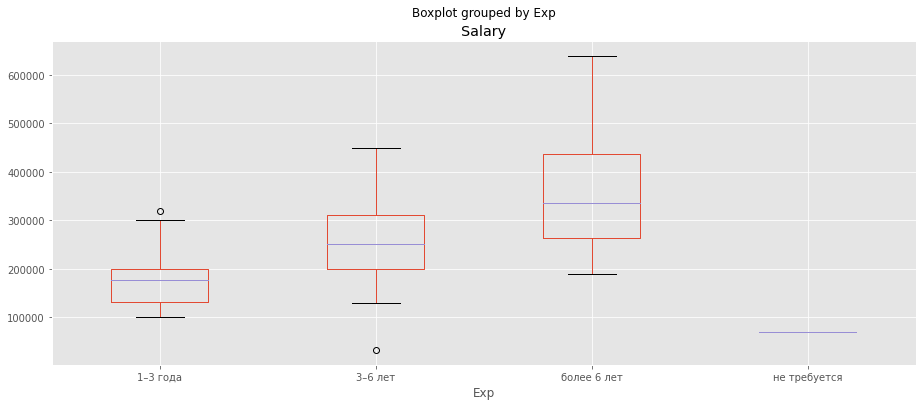

In [416]:
df.boxplot('Salary',by='Exp')

In [431]:
df['Salary'].describe()

count        65.000000
mean     238938.461538
std      115007.727583
min       32000.000000
25%      150000.000000
50%      220000.000000
75%      300000.000000
max      640000.000000
Name: Salary, dtype: float64

In [437]:
df[['Tags','Salary']].explode('Tags').groupby('Tags')['Salary'].mean().sort_values(ascending=False).iloc[:20]

Tags
AWSC                                             480000.0
CEP                                              400000.0
Bashkubernetes                                   350000.0
SQLORACLE                                        330000.0
Linuxaws                                         320000.0
SSH                                              320000.0
Automation                                       320000.0
Google                                           320000.0
Kubernetesdevopsranchersrettmdeliveryhighload    320000.0
Amazon                                           320000.0
AWSGCP                                           315000.0
AWS                                              309000.0
Patroni                                          300000.0
Go                                               282500.0
Terraform                                        281875.0
Mongo                                            280000.0
Nomad                                            280000.0
City     